<a href="https://colab.research.google.com/github/Youssef-Chip/lab1/blob/main/02_modeling_and_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

In [60]:
SEED = 42

In [61]:
# Download latest version
# /Users/mr.youssef/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2
path = "/Users/mr.youssef/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2"

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

Path to dataset files: /Users/mr.youssef/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2


In [62]:
df = pd.read_csv(os.path.join(path, csv_files[0]))

In [63]:
# Add a classification column: at_risk == 1 when exam_score < 60
df['at_risk'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[1, 0]).astype(int)

In [64]:
def log_experiment(pipeline, metrics, seed, note="", filename="experiment_log.csv"):
    """
    Logs the experiment details to a CSV file.
    """
    # Extract model name and parameters automatically
    model_step = pipeline.named_steps['classifier']
    model_name = model_step.__class__.__name__
    params = str(model_step.get_params())

    # Create the data dictionary
    data = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model': model_name,
        'random_seed': seed,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'parameters': params,
        'note': note
    }

    # Create DataFrame and append to CSV
    df = pd.DataFrame([data])

    if not os.path.isfile(filename):
        df.to_csv(filename, index=False)
    else:
        df.to_csv(filename, mode='a', header=False, index=False)

    print(f"Logged: {model_name} (F1: {metrics['f1_score']})")

# Pipeline

In [65]:
X = df.drop(columns=['student_id', 'exam_score', 'at_risk'])
y = df['at_risk']

In [66]:
X.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard
1,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate
2,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate
3,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate
4,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate


In [67]:
# Define which columns get which treatment
binary_cols = ['internet_access']
categorical_cols = ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

In [93]:
def get_metrics(y_test, y_pred):
    tp = np.sum((y_pred == 1) & (y_test == 1))
    tn = np.sum((y_pred == 0) & (y_test == 0)) 
    fp = np.sum((y_pred == 1) & (y_test == 0)) 
    fn = np.sum((y_pred == 0) & (y_test == 1)) 

    accuracy = (y_pred == y_test).mean()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "accuracy": round(accuracy, 4),
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4)
    }

In [69]:
# Create the Preprocessing Engine
preprocessor = ColumnTransformer(
    transformers=[
        # Maps 'no'/'yes' to 0/1 (OrdinalEncoder is cleaner than manual map here)
        ('binary', OrdinalEncoder(categories=[['no', 'yes']]), binary_cols),
        # Handles your One-Hot Encoding with drop_first logic
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' # Keeps any numerical columns not specified
)

# Create the Full Pipeline (Preprocessing + Scaling + Model)
pipeline_baseline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# One single call fits everything
pipeline_baseline.fit(X_train, y_train)

# Predict and Evaluate
y_pred = pipeline_baseline.predict(X_test)
metrics = get_metrics(y_test, y_pred)

log_experiment(pipeline_baseline, metrics, SEED)

Accuracy: 0.83
Precision: 0.81
Recall:    0.81
F1 Score:  0.81
Logged: GaussianNB (F1: 0.8093)


In [70]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 11) (4000, 11)
(16000,) (4000,)


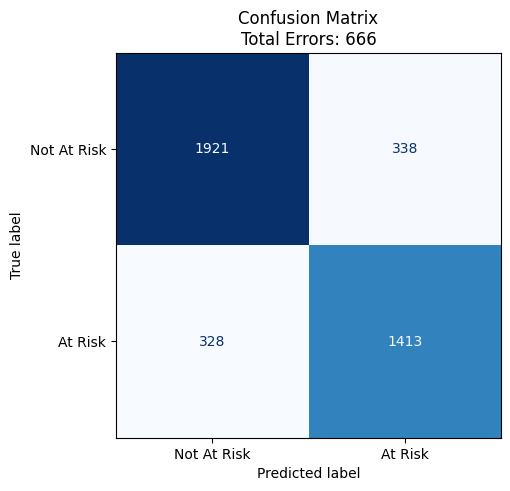

In [71]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline_baseline.classes_)
total_errors = (y_test != y_pred).sum()
labels = ['Not At Risk', 'At Risk']

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap='Blues', colorbar=False, ax=ax)

plt.title(f"Confusion Matrix\nTotal Errors: {total_errors}")
plt.show()

Model correctly predicted 1921 students not at risk (true negatives)

Model correctly predicted 1413 students at risk (true positves)

Model incorrectly predicted 338 students at risk (false positives). (These students actually passed)

Model incorrectly predicted 328 students not at risk (false negatives). (These students actually failed)

#### LINEAR SVM (LinearSVC) + TUNING

In [78]:
pipeline_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(random_state=SEED, dual='auto'))
])

# Regularization parameter: 0.1 ==> allows some points to be on the wrong side (risk = underfitting)
# 10 ==> pusnishes the model more (risk overfitting from learning from noise)
param_grid_linear = {
    'classifier__C': [0.1, 1, 10]
}
# 3-Fold CV ==> total runs 3 * 3 = 9, for each parameters train on 2 chunks (A,B), and test on a third chunk (C), then average the score
grid_linear = GridSearchCV(pipeline_linear, param_grid_linear, cv=3, scoring='f1')
grid_linear.fit(X_train, y_train)

best_linear_model = grid_linear.best_estimator_
y_pred_linear = best_linear_model.predict(X_test)
metrics_linear = get_metrics(y_test, y_pred_linear)

log_experiment(best_linear_model, metrics_linear, SEED)


Logged: LinearSVC (F1: 0.829)


## CalibratedClassifierCV with sigmoid (Platt scaling)

In [73]:
from sklearn.calibration import CalibratedClassifierCV

# 1. Initialize the Calibrated Classifier using the best linear model from earlier
calibrated_model = CalibratedClassifierCV(best_linear_model, method='sigmoid', cv=3)

# 2. Fit the calibrated model
# This retrains the model using the parameters we already tuned, but adds the
# probability layer.
print("Training calibrated model (Platt Scaling)...")
calibrated_model.fit(X_train, y_train)

# 3. Predict and Evaluate
y_proba = calibrated_model.predict_proba(X_test)
y_pred_calibrated = calibrated_model.predict(X_test)

print("\nExample Probabilities (First 5 test points):")
print(y_proba[:5])

# 4. Log the experiment
metrics_calibrated = get_metrics(y_test, y_pred_calibrated)
log_experiment(best_linear_model, metrics_calibrated, SEED, note="Calibrated (Platt Scaling)")
print("\nCalibrated Metrics:", metrics_calibrated)

Training calibrated model (Platt Scaling)...

Example Probabilities (First 5 test points):
[[1.92451232e-02 9.80754877e-01]
 [9.76779640e-01 2.32203601e-02]
 [3.00871958e-01 6.99128042e-01]
 [9.99607739e-01 3.92260563e-04]
 [9.80248317e-01 1.97516825e-02]]
Accuracy: 0.85
Precision: 0.82
Recall:    0.83
F1 Score:  0.83
Logged: LinearSVC (F1: 0.8286)

Calibrated Metrics: {'accuracy': np.float64(0.8515), 'precision': np.float64(0.8248), 'recall': np.float64(0.8325), 'f1_score': np.float64(0.8286)}


Calculating the probabilities for 5 students, we see that:
- The model is 98% sure that student 1 is at risk
- The model is 97.6% sure that student 2 is NOT at risk
- The model is 69.9% sure that student 3 is at risk
- The model is 99.9% sure that student 4 is NOT at risk
- The model is 98% sure that student 5 is NOT at risk

We were also able to maintain the F1 score (0.83), meaning that the calibrating the model to give probabilities didn't affect it's output

In [100]:
# We need to pick a new threshold other than 50%
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', SVC(C=1, kernel='rbf', probability=True, random_state=42)) 
])

pipeline_final.fit(X_train, y_train)
y_probs = pipeline_final.predict_proba(X_test)[:, 1]

target_recall = 0.90
best_threshold = 0
best_f1_constrained = 0

for thresh in np.arange(0.01, 0.99, 0.01):
    temp_preds = (y_probs >= thresh).astype(int)
    m = get_metrics(y_test, temp_preds)
    
    if m['recall'] >= target_recall:
        if m['f1_score'] > best_f1_constrained:
            best_f1_constrained = m['f1_score']
            best_threshold = thresh

print(f"New Optimal Threshold: {best_threshold:.2f}")

New Optimal Threshold: 0.29


In [101]:
y_pred_default = (y_probs >= 0.50).astype(int)
y_pred_new = (y_probs >= best_threshold).astype(int)

metrics_default = get_metrics(y_test, y_pred_default)
metrics_new = get_metrics(y_test, y_pred_new)

In [102]:
metrics_default

{'accuracy': np.float64(0.8472),
 'precision': np.float64(0.83),
 'recall': np.float64(0.8162),
 'f1_score': np.float64(0.8231)}

In [97]:
metrics_new

{'accuracy': np.float64(0.8222),
 'precision': np.float64(0.7445),
 'recall': np.float64(0.9006),
 'f1_score': np.float64(0.8152)}

In [98]:
log_experiment(pipeline_final, metrics_new, SEED)

Logged: SVC (F1: 0.8152)


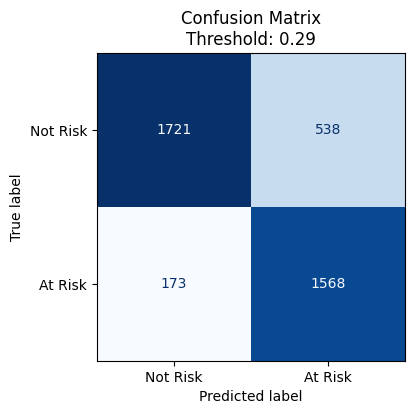

In [99]:
cm = confusion_matrix(y_test, y_pred_new)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Risk', 'At Risk'])
disp.plot(cmap='Blues', colorbar=False, ax=ax)

plt.title(f"Confusion Matrix\nThreshold: {best_threshold:.2f}")
plt.show()

Model correctly predicted 1721 students not at risk (true negatives)

Model correctly predicted 1568 students at risk (true positves)

Model incorrectly predicted 538 students at risk (false positives). (These students actually passed)

Model incorrectly predicted 173 students not at risk (false negatives). (These students actually failed)